In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import h5py
from scipy import signal
from scipy.optimize import curve_fit

## Window

I'm using a Tukey window. Has a nice flat region. Blackman window (that minimizes spectral leakage) gives slightly better SNR for GW150914. It's used in LIGO tutorial. But I've stuck with Tukey for all events here. Data and template are pre-whitened before doing Matched Filtering. Pre-whitening, in our case, is most useful for visualization purposes only (equivalent to splitting Ninv into two sqrt(Ninv)), but doing it anyway.

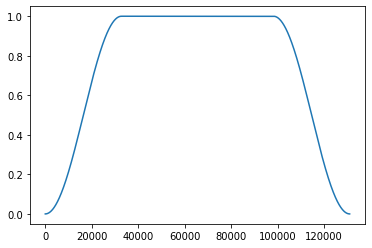


## Noise estimation

For each detector, I average over the power spectrum obtained from all available datasets (4 in our case). Since the GW signal all 4 events is quite small compared to noise for most frequencies, this reduces the random noise in each mode. Then I smooth the power spectrum with a gaussian kernel to obtain the final noise power for each detector. This is then used for detecting all events.


## SNR and Combined SNR

Analytical SNR is given by the usual $\large \frac{m}{\sigma_m}$

where $m$ is the MF amplitude, and $\sigma_m = (A^T N^{-1} A)^{-1/2}$

SNR can be added in quadrature: Combined SNR = $\sqrt{SNR_h^2 + SNR_l^2}$

## Weights

Matched filtering equation reduces down to

$m = IFT \big(\large \frac{\tilde{d}\tilde{A}}{P_N}\big)$ where $P_N$ is the noise power spectrum. Thus, we're basically weighting each mode of data in fourier space by a weight $\tilde{A}/P_N$. Equivalently, if we were working with pre-whitened data, the corresponding weight for each mode would be $\tilde{A}/\sqrt{P_N}$ since one factor of $\sqrt{P_N}$ has been consumed by d. The result is just the pre-whitened template. I shall be calculating the weight using the second method, since I am pre-whitening my data. 

The half-weight point tells us what frequencies (of our template) contribute most strongly to the observed signal.


## Localization and Position uncertainty

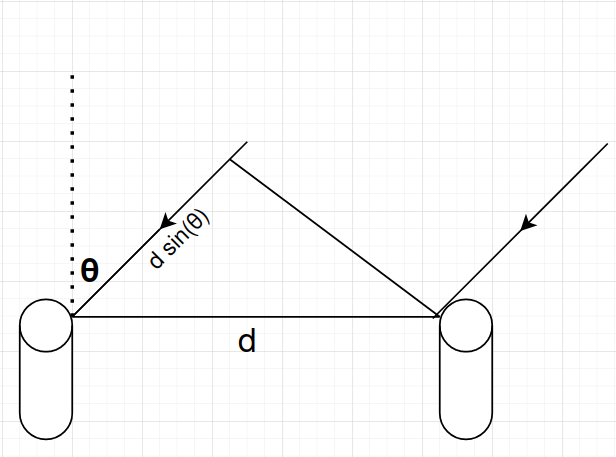

Let $\tau$ be the time delay to one of the detectors. We know that

$\tau = d sin\theta/c$ (c = speed of light)

or

$ \theta = f(\tau) = sin^{-1}(c \tau/d)$

Therefore, $\large \Delta \theta = \frac{df}{d\tau} \Delta \tau = \frac{c \Delta \tau}{d} \Big[1 - \big(\frac{c\tau}{d}\big)^2\Big]^{-1/2}$

$\tau$ is `timediff` in below code: the delay between the two detectors. The uncertainty in delay is `delay_sigma` that's calculated as follows:

Error on matched filter delay (how well we can localize where the signal is in the data) for each detector is calculated by fitting a gaussian to the main peak and using it's width. This is really an upper-limit. $\Delta \chi^2 \approx 1$ for much less than this width, I think. If error on the delay for each detector is $\sigma_1$ and $\sigma_2$ respectively, the error on their difference is $\sqrt{\sigma_1^2 + \sigma_2^2}$ (variances add.)

Likelihood for localization is constructed as $\large exp\Big(-\frac{(\tau_p-\tau)^2}{2\Delta\tau^2}\Big)$. $\tau_p$ is delay for a particular map pixel, obtained by dotting the baseline with direction vector of the pixel (usual radio astronomy technique).

In [2]:
def mygauss(x,mu,sigma,amp):
    f=amp*np.exp(-0.5*(x-mu)**2/sigma**2)
    return f

In [3]:
def smooth(data,sigma=5):
    dataft=np.fft.rfft(data)
    x=np.fft.fftfreq(len(data))*len(data)
    gauss=np.exp(-0.5*(x**2)/sigma**2)
    gauss=gauss/gauss.sum()
    kernelft=np.fft.rfft(gauss)
    res=np.fft.irfft(dataft*kernelft)
    return res

In [4]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_raw(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    return strain,dt,utc

In [5]:


def get_xcorr(strain,template,window,noise_ps):
    N=len(strain)
    dataft = np.fft.fft(strain*window)
    # whitening is only useful for visualization in this case
    dataft_white = dataft/np.sqrt(noise_ps)
    tempft = np.fft.fft(template*window)
    tempft_white = tempft/np.sqrt(noise_ps)
    
    weights = np.abs(tempft_white[:N//2])
    wt_sum = weights.sum()
    idhalf = np.argmin(np.abs(weights.cumsum()-wt_sum/2))
    print("Half the weight is contributed by frequencies upto:", idhalf*4096/N, "Hz")
    
    lhs = np.sum(template*N*np.fft.ifft(tempft/noise_ps))
    rhs = np.fft.ifft(tempft_white*N*np.conj(dataft_white))
    xcorr=np.abs(rhs)/np.abs(lhs)
    return rhs,lhs
    

In [6]:
rootdir = './LOSC_Event_tutorial-master/'
with open(rootdir+"BBH_events_v3.json", "r") as read_file:
    events = json.load(read_file)

In [7]:
eventnames = list(events.keys())

### NOISE ESTIMATION

In [8]:
han_ps = []
liv_ps = []
# sos = signal.butter(6, 0.9, 'low',output='sos')

for event in eventnames:
    fname=events[event]['fn_H1']
    strain,dt,utc = read_raw(rootdir+fname)
    N=len(strain)
    
    win=signal.windows.tukey(N)
#     strain_filt=signal.sosfilt(sos,strain*win)
    dataft = np.fft.fft(win*strain)
#     dataft = np.fft.fft(strain_filt)
    ps=np.abs(dataft)**2
    han_ps.append(ps)
    
    fname=events[event]['fn_L1']
    strain,dt,utc = read_raw(rootdir+fname)
    N=len(strain)
    win=signal.windows.tukey(N)
    dataft = np.fft.fft(win*strain)
#     strain_filt=signal.sosfilt(sos,strain*win)
#     dataft = np.fft.fft(win*strain_filt)
    ps=np.abs(dataft)**2
    liv_ps.append(ps)

han_ps = np.mean(np.asarray(han_ps),axis=0).ravel()
liv_ps = np.mean(np.asarray(liv_ps),axis=0).ravel()

Text(0.5, 1.0, 'Livingston Noise')

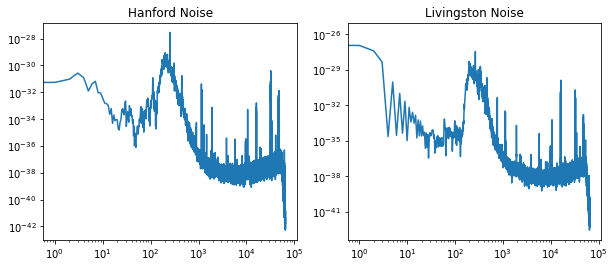

In [9]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.loglog(han_ps[:N//2])
plt.title('Hanford Noise')

plt.subplot(122)
plt.loglog(liv_ps[:N//2])
plt.title('Livingston Noise')

In [10]:
han_ps_smooth = smooth(han_ps,6)
liv_ps_smooth = smooth(liv_ps,6)

Text(0.5, 1.0, 'Livingston Noise')

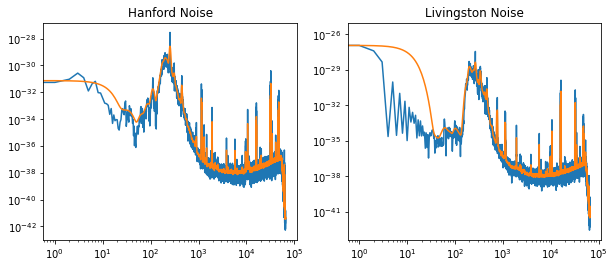

In [11]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.loglog(han_ps[:N//2])
plt.loglog(han_ps_smooth[:N//2])
plt.title('Hanford Noise')

plt.subplot(122)
plt.loglog(liv_ps[:N//2])
plt.loglog(liv_ps_smooth[:N//2])
plt.title('Livingston Noise')

In [12]:
template_name=events[eventnames[0]]['fn_template']

#Hanford
fname=events[eventnames[0]]['fn_H1']
strain,dt,utc = read_raw(rootdir+fname)
th,tl = read_template(rootdir+template_name)
template = th
rhs,lhs=get_xcorr(strain,template,win,han_ps_smooth)
xcorr_h=np.abs(rhs)/np.abs(lhs)
idmax_h=np.argmax(xcorr_h)
noise1_h = np.sqrt(1/np.abs(lhs)) #analytically expected error bar on amplitude
mynoise_h=np.std(xcorr_h[:40000]) #from scatter in data



#livingston
fname=events[eventnames[0]]['fn_L1']
strain,dt,utc = read_raw(rootdir+fname)
th,tl = read_template(rootdir+template_name)
template = th
rhs,lhs=get_xcorr(strain,template,win,liv_ps_smooth)
xcorr_l=np.abs(rhs)/np.abs(lhs)
idmax_l=np.argmax(xcorr_l)
noise1_l = np.sqrt(1/np.abs(lhs)) #analytically expected error bar on amplitude
mynoise_l=np.std(xcorr_l[:40000]) #from scatter in data

Half the weight is contributed by frequencies upto: 125.0625 Hz
Half the weight is contributed by frequencies upto: 134.78125 Hz


(-0.435546875, -0.43115234375)

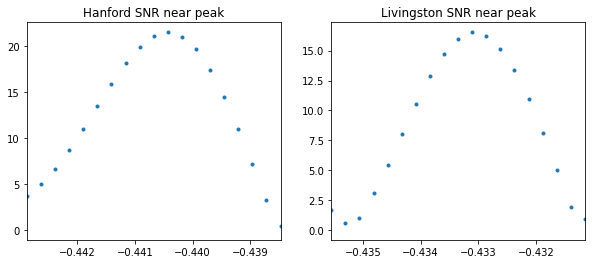

In [13]:
f=plt.gcf()
f.set_size_inches(10,4)
t = np.fft.fftfreq(len(strain))*len(strain)*dt
plt.subplot(121)
snr_h = xcorr_h/noise1_h
plt.plot(t,snr_h,'.')
plt.title('Hanford SNR near peak')
plt.xlim(t[idmax_h-10],t[idmax_h+8])

plt.subplot(122)
snr_l = xcorr_l/noise1_l
plt.plot(t,snr_l,'.')
plt.title('Livingston SNR near peak')
plt.xlim(t[idmax_l-10],t[idmax_l+8])

In [14]:
#git amp, mean, width

fitp_h,cov_h=curve_fit(mygauss,t[idmax_h-10:idmax_h+8],snr_h[idmax_h-10:idmax_h+8],p0=[-0.4405,0.002,20])
fitp_l,cov_l=curve_fit(mygauss,t[idmax_l-10:idmax_l+8],snr_l[idmax_l-10:idmax_l+8],p0=[-0.433,0.002,16])

In [15]:
print(fitp_h,fitp_l)

[-4.40554357e-01  1.14135141e-03  2.16659979e+01] [-4.33097569e-01  9.55358589e-04  1.70480522e+01]


In [16]:
print(f"HANFORD ampl: {np.max(xcorr_h):4.2e} ")
print(f"analy   noise: {noise1_h:4.2e}  analy   SNR: {np.max(xcorr_h)/noise1_h:4.2f}")
print(f"scatter noise: {mynoise_h:4.2e}  scatter SNR: {np.max(xcorr_h)/mynoise_h:4.2f}")
print(f"LIVINGS ampl: {np.max(xcorr_l):4.2e} ")
print(f"analy   noise: {noise1_l:4.2e}  analy   SNR: {np.max(xcorr_l)/noise1_l:4.2f}")
print(f"scatter noise: {mynoise_l:4.2e}  scatter SNR: {np.max(xcorr_l)/mynoise_l:4.2f}")

print(f"\nCombined analy SNR: {np.sqrt(snr_h[idmax_h]**2+snr_l[idmax_l]**2):4.2f}")

HANFORD ampl: 1.19e-03 
analy   noise: 5.55e-05  analy   SNR: 21.49
scatter noise: 3.97e-05  scatter SNR: 30.09
LIVINGS ampl: 1.01e-03 
analy   noise: 6.11e-05  analy   SNR: 16.54
scatter noise: 4.49e-05  scatter SNR: 22.50

Combined analy SNR: 27.12


In [17]:
timediff = (idmax_h - idmax_l)*dt # time delay between the two stations
delay_sigma = np.sqrt(fitp_h[1]**2 + fitp_l[1]**2)
print(f"Time delay b/w 2 stations is {timediff:5.2e} s, and error on it is: {delay_sigma:5.2e} s")

Time delay b/w 2 stations is -7.32e-03 s, and error on it is: 1.49e-03 s


### This time of 7 ms delay matches exactly what LIGO published in 2016, and also presented in a press release.

https://www.ligo.caltech.edu/news/ligo20160211

### POSITION ERROR and LOCALIZATION MAP

In [18]:
c=3e8 #m/s
d=3e6 # m
pos_error = c * np.abs(delay_sigma)/d / np.sqrt(1 - (c*np.abs(timediff)/d)**2)

print(f"Error in position is {pos_error*180/np.pi:4.2f} degrees")

Error in position is 12.53 degrees


In [19]:
import healpy as hp

In [20]:
coor_liv = np.deg2rad(np.asarray([30+(33/60)+(46.42/3600), -(90+46/60+27.27/3600)]))
coor_han = np.deg2rad(np.asarray([46+27/60+18.52/3600, -(119+24/60+27.56/3600)]))

han = np.asarray([np.cos(coor_han[0])*np.cos(coor_han[1]), np.cos(coor_han[0])*np.sin(coor_han[1]), np.sin(coor_han[0])])
liv = np.asarray([np.cos(coor_liv[0])*np.cos(coor_liv[1]), np.cos(coor_liv[0])*np.sin(coor_liv[1]), np.sin(coor_liv[0])])

In [21]:
coor_liv

array([ 0.53342314, -1.58430939])

In [22]:
nside=256
pix_th,pix_phi = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)))

In [23]:
b = (han-liv)*6378000 #m
# b = (liv-han)*6378000

In [24]:
np.sqrt(b@b)

3001988.684633395

In [25]:
prob = np.zeros(hp.nside2npix(nside))

In [26]:
for i in range(hp.nside2npix(nside)):
    th,phi=pix_th[i],pix_phi[i]
    n = np.asarray([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    delay = b@n/3e8
    prob[i] = np.exp(-0.5*(delay-timediff)**2/delay_sigma**2)
    

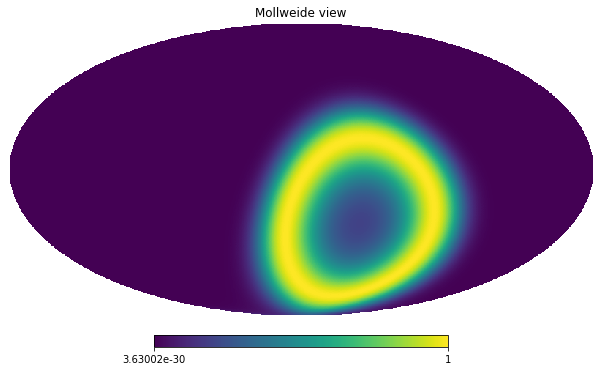

In [27]:
hp.mollview(prob)